In [4]:
import os
from os.path import join
import sys
sys.path.insert(0, "/opt/src")
from dfba import DfbaModel, ExchangeFlux, KineticVariable, ControlParameter
from plotly import graph_objects as go
from functools import partial
from dfba.plot.plotly import *
from GSMMutils.experimental.ExpMatrix import *
from GSMMutils.model.COBRAmodel import MyModel
import sympy as sp
from sympy import Max, Min
from sympy.functions import Abs
from GSMMutils import DATA_PATH
import json
from joblib import Parallel
import numbers
import matplotlib.pyplot as plt
from GSMMutils.dynamic.run_dfba import *

Loading

Reactions: 3515
Metabolites: 3660
Genes: 1690
Model loaded


In [5]:
def read_model():
    fba_model = MyModel(join(DATA_PATH, "models/model_dfba.xml"), "e_ActiveBiomass__cytop")
    fba_model.exchanges.EX_C00011__dra.bounds = (-10000, 10000)
    fba_model.solver = "glpk"
    [setattr(x, 'objective_coefficient', 0) for x in fba_model.reactions if x.objective_coefficient != 0]

    objectives = {"e_ActiveBiomass__cytop": 1,
        "DM_C00369__chlo": 1,
        "DM_C05306__chlo": 1, "DM_C05307__chlo": 1,
        "DM_C08601__chlo": 1, "DM_C02094__chlo": 1,
        "DM_C00116__cytop": 1, "DM_C00422__lip": 1,
        "EX_C00244__dra": -1, "EX_C00009__dra": -1
                 }

    for reaction_id, value in objectives.items():
        fba_model.reactions.get_by_id(reaction_id).objective_coefficient = value
    return fba_model

fba_model = read_model()
matrix = ExpMatrix(f"{DATA_PATH}/experimental/Matriz- DCCR Dunaliella salina_dfba.xlsx")
matrix.conditions = "Resume"

Loading

Reactions: 3515
Metabolites: 3660
Genes: 1690
Model loaded


Loading

Reactions: 3515
Metabolites: 3660
Genes: 1690
Model loaded


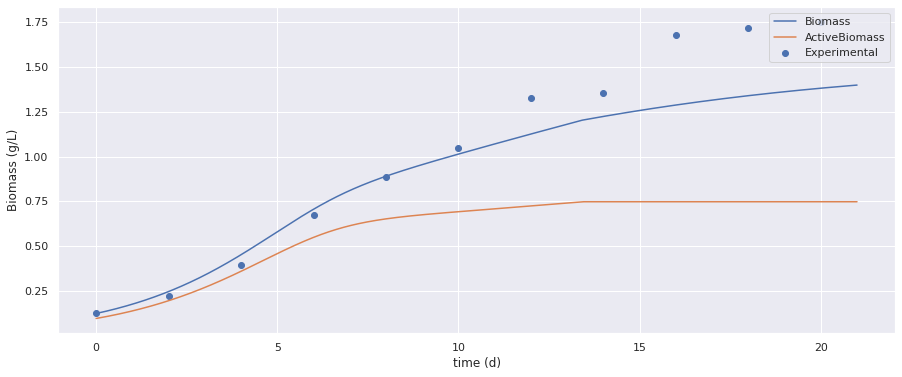

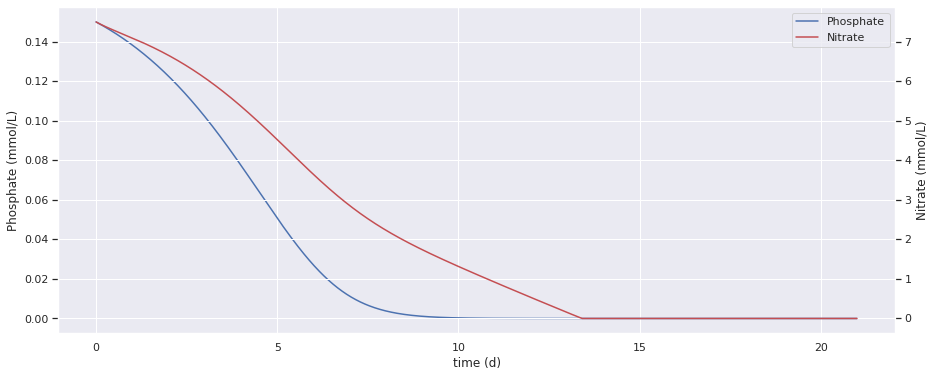

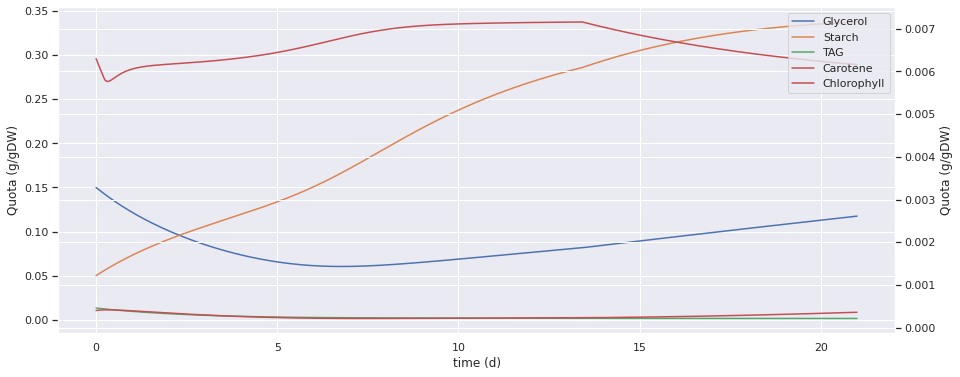

In [3]:
import sys
sys.path.insert(0, "/opt/src")
from GSMMutils.dynamic.run_dfba import *
initial_parameters = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json", "r"))
concentrations, trajectories = create_dfba_model("3", initial_parameters, True)

,time,ActiveBiomass,Biomass,Carotene,Chlorophyll,Glycerol,Light,Lutein,Nitrate,Nitrogen_quota,...,Phosphate_quota,Starch,Starch_concentration,TAG,Protein,Carbohydrate,Lipid,Carotene_concentration,Chlorophyll_concentration,Lutein_concentration
0,0.000000,0.098585,0.126359,0.000400,0.006300,0.150000,0.0,0.000840,7.500000,5.150000,...,0.240000,0.050000,0.006318,0.013100,0.236861,0.337956,0.155627,0.000051,0.000796,0.000106
1,0.020833,0.099321,0.127251,0.000403,0.006256,0.149253,0.0,0.000839,7.489587,5.195692,...,0.239933,0.050557,0.006433,0.013009,0.236957,0.338630,0.155594,0.000051,0.000796,0.000107
2,0.041667,0.100063,0.128149,0.000406,0.006212,0.148513,0.0,0.000837,7.479369,5.238967,...,0.239865,0.051111,0.006550,0.012919,0.237052,0.339300,0.155562,0.000052,0.000796,0.000107
3,0.062500,0.100809,0.129053,0.000409,0.006169,0.147777,0.0,0.000836,7.469335,5.279953,...,0.239798,0.051661,0.006667,0.012830,0.237147,0.339965,0.155529,0.000053,0.000796,0.000108
4,0.083333,0.101560,0.129963,0.000411,0.006125,0.147048,0.0,0.000834,7.459475,5.318776,...,0.239732,0.052208,0.006786,0.012742,0.237240,0.340626,0.155497,0.000053,0.000796,0.000108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,20.916667,0.746607,1.379870,0.000367,0.006105,0.101029,0.0,0.001044,-0.001239,5.906443,...,0.130894,0.348682,0.481897,0.001316,0.164264,0.548380,0.100159,0.000506,0.008424,0.001440
1005,20.937500,0.746607,1.380226,0.000367,0.006103,0.101114,0.0,0.001045,-0.001239,5.904920,...,0.130860,0.348737,0.482098,0.001316,0.164221,0.548384,0.100133,0.000507,0.008424,0.001442
1006,20.958333,0.746607,1.380581,0.000368,0.006102,0.101198,0.0,0.001046,-0.001239,5.903401,...,0.130826,0.348792,0.482298,0.001316,0.164179,0.548387,0.100108,0.000508,0.008424,0.001444
1007,20.979167,0.746607,1.380936,0.000369,0.006100,0.101283,0.0,0.001047,-0.001239,5.901887,...,0.130793,0.348846,0.482497,0.001316,0.164137,0.548391,0.100082,0.000509,0.008424,0.001446


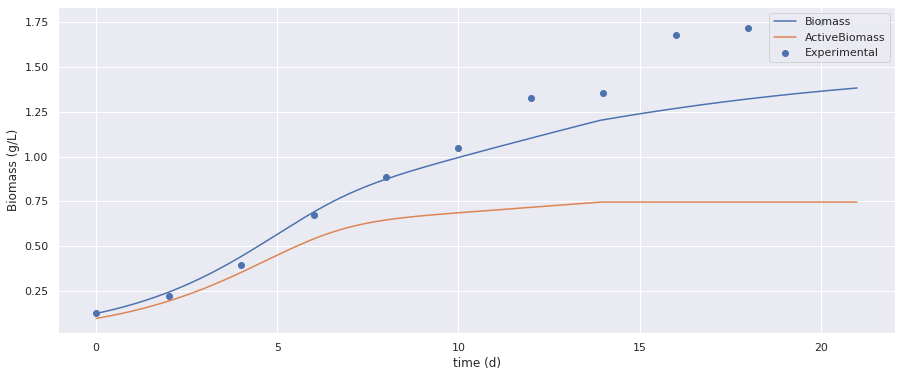

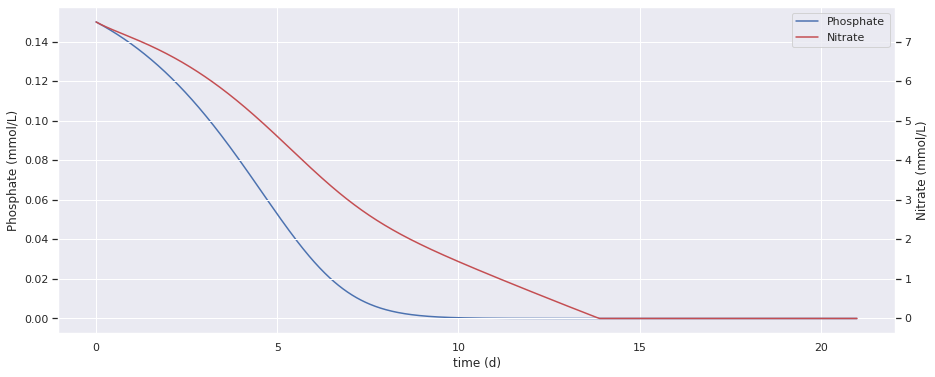

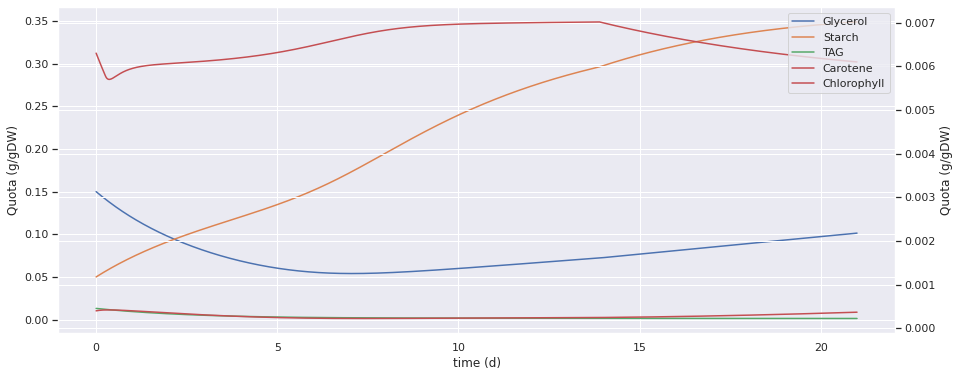

In [26]:
initial_parameters = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json", "r"))
create_dfba_model("3", initial_parameters, True)[0]

In [5]:
create_dfba_model("3", initial_parameters, False)[0]

,time,ActiveBiomass,Biomass,Carotene,Chlorophyll,Glycerol,Light,Lutein,Nitrate,Nitrogen_quota,...,Phosphate_quota,Starch,Starch_concentration,TAG,Protein,Carbohydrate,Lipid,Carotene_concentration,Chlorophyll_concentration,Lutein_concentration
0,0.000000,0.098585,0.126359,0.000400,0.006300,0.150000,0.0,0.000840,7.500000,5.150000,...,0.240000,0.050000,0.006318,0.013100,0.236861,0.337956,0.155627,0.000051,0.000796,0.000106
1,0.020833,0.099331,0.127399,0.000402,0.006249,0.150156,0.0,0.000836,7.489623,5.189379,...,0.239673,0.050505,0.006434,0.012994,0.236706,0.338273,0.155428,0.000051,0.000796,0.000107
2,0.041667,0.100084,0.128445,0.000405,0.006198,0.150300,0.0,0.000833,7.479392,5.226713,...,0.239352,0.051005,0.006552,0.012890,0.236556,0.338591,0.155233,0.000052,0.000796,0.000107
3,0.062500,0.100842,0.129498,0.000406,0.006147,0.150433,0.0,0.000829,7.469297,5.262115,...,0.239037,0.051501,0.006670,0.012786,0.236410,0.338909,0.155042,0.000053,0.000796,0.000107
4,0.083333,0.101606,0.130557,0.000408,0.006098,0.150556,0.0,0.000825,7.459330,5.295690,...,0.238727,0.051993,0.006788,0.012684,0.236268,0.339228,0.154854,0.000053,0.000796,0.000108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,20.916667,0.739198,1.400779,0.000372,0.006149,0.159689,0.0,0.000964,-0.002664,5.818976,...,0.128936,0.303455,0.425752,0.001304,0.160206,0.498221,0.097705,0.000521,0.008613,0.001351
1005,20.937500,0.739198,1.401055,0.000373,0.006148,0.159774,0.0,0.000965,-0.002664,5.817830,...,0.128910,0.303475,0.425863,0.001303,0.160174,0.498202,0.097686,0.000522,0.008613,0.001353
1006,20.958333,0.739198,1.401331,0.000373,0.006146,0.159858,0.0,0.000966,-0.002664,5.816687,...,0.128885,0.303494,0.425974,0.001303,0.160143,0.498183,0.097667,0.000523,0.008613,0.001354
1007,20.979167,0.739198,1.401605,0.000374,0.006145,0.159942,0.0,0.000967,-0.002664,5.815548,...,0.128860,0.303513,0.426083,0.001303,0.160112,0.498163,0.097648,0.000524,0.008613,0.001356


In [1]:
import os
from os.path import join
import sys
sys.path.insert(0, "/opt/src")
from dfba import DfbaModel, ExchangeFlux, KineticVariable, ControlParameter
from plotly import graph_objects as go
from functools import partial
from dfba.plot.plotly import *
from GSMMutils.experimental.ExpMatrix import *
from GSMMutils.model.COBRAmodel import MyModel
import sympy as sp
from sympy import Max, Min
from sympy.functions import Abs
from GSMMutils import DATA_PATH
import json
from joblib import Parallel
import numbers
import matplotlib.pyplot as plt
from GSMMutils.dynamic.run_dfba import *

Loading

Reactions: 3515
Metabolites: 3660
Genes: 1690
Model loaded


In [8]:
matrix = ExpMatrix(f"{DATA_PATH}/experimental/Matriz- DCCR Dunaliella salina_dfba.xlsx")
matrix.conditions = "Resume"
initial_parameters = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json", "r"))

def read_model() -> MyModel:
    """
    Reads the model from the xml file and sets the objective function to the biomass reaction, demands, and minimizes the nitrate and phosphorus uptake.
    Returns
        MyModel: The model with the objective function set to the biomass reaction and the nitrate and phosphorus uptake minimized.
    -------

    """
    stoichiometric_model = MyModel(join(DATA_PATH, "models/model_dfba_no_caro.xml"), "e_ActiveBiomass__cytop")
    stoichiometric_model.exchanges.EX_C00011__dra.bounds = (-10000, 10000)
    stoichiometric_model.solver = "glpk"
    [setattr(x, 'objective_coefficient', 0) for x in stoichiometric_model.reactions if x.objective_coefficient != 0]

    objectives = {
        "e_ActiveBiomass__cytop": 1,
        "DM_C08601__chlo": 1, "DM_C02094__chlo": 1,
        "EX_C00244__dra": -1, "EX_C00009__dra": -1
    }
    for reaction_id, value in objectives.items():
        stoichiometric_model.reactions.get_by_id(reaction_id).objective_coefficient = value
    return stoichiometric_model

def create_dfba_model(condition, parameters, create_plots=False):
    
    if 'Time (d)' not in matrix.matrix[condition].columns:
        matrix.matrix[condition]['Time (d)'] = matrix.matrix[condition].index
    fba_model = read_model()
    dfba_model = DfbaModel(fba_model)
    dfba_model.solver_data.set_display("none")
    dfba_model.solver_data.set_algorithm("direct")
    #     dfba_model.solver_data.set_rel_tolerance(1e-3)
    #     dfba_model.solver_data.set_ode_method("ADAMS")

    kinetic_vars = get_kinetic_variables()
    parameters.update(kinetic_vars)
    dfba_model.add_kinetic_variables(list(kinetic_vars.values()))

    exchange_fluxes = {}
    for key, value in get_exchange_fluxes().items():
        exchange_fluxes[key] = ExchangeFlux(value)

    dfba_model.add_exchange_fluxes(list(exchange_fluxes.values()))
    parameters.update(exchange_fluxes)
    parameters['caro_production'] = parameters['v_C'] * 536.87 / 1000
    parameters['lutein_production'] = parameters['v_lutein'] * 568.87 / 1000
    parameters['total_growth_rate'] = (parameters['mu'] +
                                       parameters['caro_production'] +
                                       parameters['lutein_production'])

    for key, value in get_dynamic_expressions(parameters).items():
        dfba_model.add_rhs_expression(key, value)

    """
    Experiment-dependent
    """
    parameters["Eo"] = matrix.conditions["Light (umol/m^2.s)"].loc[condition]
    parameters["nacl"] = matrix.conditions["Salinity g/L"].loc[condition]
    parameters["Lr"] = matrix.conditions["Lr"].loc[condition]
    parameters["aeration"] = matrix.conditions["Aeration rate"].loc[condition]

    light_sources = matrix.conditions["Light sources"].loc[condition].split(",")
    for light_source in light_sources:
        fba_model.reactions.get_by_id(light_source).bounds = (0, 10000)

    """
    General parameters
    """
    parameters['chlorophyll'] = 0.0063
    parameters["q"] = parameters["n_quota"] / parameters["wNmax"]
    parameters["n"] = 1 - (parameters["q"] / (parameters["q"] + parameters["K_nitrogen_quota"]))
    parameters["nitrogen_mass_quota"] = parameters["n_quota"] * 14.01 / 1000
    parameters["phosphate_mass_quota"] = parameters["p_quota"] * 30.97 / 1000

    """
    Light
    """
    parameters["Ex"], parameters["Ex0"] = get_bounds("light", parameters)
    dfba_model.add_exchange_flux_lb("EX_C00205__dra", sp.Max(sp.N(parameters["Ex"]), 0), parameters["light"])

    """
    NO3
    """
    dfba_model.add_exchange_flux_lb("EX_C00244__dra", get_bounds("nitrate", parameters), parameters["nitrate"])  # 4.07
    #     nitrate_quota = sp.Max(0, 1 - (4.8697 * F / X) / n_quota)
    dfba_model.add_exchange_flux_lb("DM_C00244__cytop", sp.Max(0, parameters["v_nitrate_max"] * (
            1 - parameters['wNmin'] / parameters["n_quota"])), parameters["nitrate"])

    """
    HPO4
    """
    dfba_model.add_exchange_flux_lb("EX_C00009__dra", get_bounds("phosphate", parameters), parameters["phosphorus"])
    #     polyP_quota = sp.Max(0, 1 - (0.295 * F / X) / p_quota)
    dfba_model.add_exchange_flux_lb("DM_C00404__vacu", get_bounds("polyphosphate", parameters))

    """
    Starch
    """
    # dfba_model.add_exchange_flux_lb("DM_C00369__chlo", get_bounds("starch_consumption", parameters))
#     dfba_model.add_exchange_flux_ub("DM_C00369__chlo", get_bounds("starch_production", parameters), parameters["starch"])

    """
    Carotene
    """
    dfba_model.add_exchange_flux_ub("DM_C02094__chlo", get_bounds("carotene", parameters), parameters["carotene"])

    """
    Lutein
    """
    dfba_model.add_exchange_flux_ub("DM_C08601__chlo", get_bounds("lutein", parameters), parameters["lutein"])

    """
    Chlorophyll
    """
#     sum_chl = get_bounds("chlorophyll", parameters)
#     dfba_model.add_exchange_flux_lb("DM_C05306__chlo", Abs(Min(sum_chl, 0)) * 1.73 / 2.73, parameters["chlorophyll"])
#     dfba_model.add_exchange_flux_lb("DM_C05307__chlo", Abs(Min(sum_chl, 0)) / 2.73, parameters["chlorophyll"])
#     dfba_model.add_exchange_flux_ub("DM_C05306__chlo", Max(sum_chl, 0) * 1.73 / 2.73, parameters["chlorophyll"])
#     dfba_model.add_exchange_flux_ub("DM_C05307__chlo", Max(sum_chl, 0) / 2.73, parameters["chlorophyll"])

    """
    Glycerol
    """
    # wgly_max = 0.17  # https://doi.org/10.1016/j.biortech.2008.02.042
#     dfba_model.add_exchange_flux_ub("DM_C00116__cytop", get_bounds("glycerol", parameters), parameters["glycerol"])

    """
    TAG
    """
#     dfba_model.add_exchange_flux_ub("DM_C00422__lip", get_bounds("tag", parameters), parameters["tag"])

    """
    CO2
    """
#     dfba_model.add_exchange_flux_lb("EX_C00011__dra", get_bounds("co2", parameters))

    """
    Simulate
    """
    dfba_model.add_initial_conditions(get_initial_conditions(matrix, condition))
    max_time = max(matrix.matrix[condition]['Time (d)'].astype(float).tolist()) + 1
    time_step = 1 / 48
    concentrations, trajectories = dfba_model.simulate(0.0, max_time, time_step,
                                                       ["e_ActiveBiomass__cytop", 'EX_C00009__dra',
                                                        "DM_C02094__chlo", "EX_C00244__dra",
                                                        "EX_C00011__dra",
                                                        "DM_C00404__vacu",
                                                        "DM_C00244__cytop", "EX_C00205__dra", "DM_C08601__chlo",
                                                        ])

    active_biomass_fraction = concentrations['ActiveBiomass'] / concentrations['Biomass']
    concentrations.loc[:, 'Protein'] = abs(fba_model.reactions.e_ActiveBiomass__cytop.metabolites[
                                               fba_model.metabolites.e_Protein__cytop]) * active_biomass_fraction
    carbs = abs(fba_model.reactions.e_ActiveBiomass__cytop.metabolites[
                    fba_model.metabolites.e_Carbohydrate__cytop]) * active_biomass_fraction
    concentrations.loc[:, 'Carbohydrate'] = carbs
    polar_lipids = abs(fba_model.reactions.e_ActiveBiomass__cytop.metabolites[
                           fba_model.metabolites.e_Lipid__cytop]) * active_biomass_fraction
    concentrations.loc[:, 'Lipid'] = polar_lipids

    indexes = matrix.matrix[condition].index.astype(float)
    indexes = [e for e in indexes]
    experimental = [(indexes, matrix.matrix[condition]["DW"].tolist())]

    concentrations.loc[:, "Carotene_concentration"] = concentrations['Carotene'] * concentrations['Biomass']
    concentrations.loc[:, 'Lutein_concentration'] = concentrations['Lutein'] * concentrations['Biomass']

    return concentrations, trajectories

concentrations, trajectories = create_dfba_model( "3", initial_parameters, True)
concentrations

Loading



Ignoring initial condition for Starch since it does notcorrespond to a kinetic variable in the model.
Ignoring initial condition for Starch_concentration since it does notcorrespond to a kinetic variable in the model.
Ignoring initial condition for Chlorophyll since it does notcorrespond to a kinetic variable in the model.
Ignoring initial condition for Glycerol since it does notcorrespond to a kinetic variable in the model.
Ignoring initial condition for TAG since it does notcorrespond to a kinetic variable in the model.


Reactions: 3512
Metabolites: 3660
Genes: 1690
Model loaded


,time,ActiveBiomass,Biomass,Carotene,Light,Lutein,Nitrate,Nitrogen_quota,Phosphate,Phosphate_quota,Protein,Carbohydrate,Lipid,Carotene_concentration,Lutein_concentration
0,0.000000,0.098585,0.126359,0.000400,0.0,0.000840,7.500000,5.150000,1.500000e-01,0.240000,0.127407,0.387635,0.086922,0.000051,0.000106
1,0.020833,0.099956,0.127731,0.000402,0.0,0.000835,7.489565,5.176318,1.497941e-01,0.239034,0.127791,0.388803,0.087184,0.000051,0.000107
2,0.041667,0.101342,0.129119,0.000403,0.0,0.000831,7.479170,5.201167,1.495860e-01,0.238080,0.128171,0.389959,0.087443,0.000052,0.000107
3,0.062500,0.102743,0.130520,0.000405,0.0,0.000826,7.468809,5.224634,1.493757e-01,0.237136,0.128546,0.391101,0.087699,0.000053,0.000108
4,0.083333,0.104158,0.131937,0.000406,0.0,0.000822,7.458478,5.246799,1.491632e-01,0.236203,0.128918,0.392232,0.087953,0.000054,0.000108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,20.916667,1.170490,1.200111,0.000375,0.0,0.001297,-0.001395,6.787289,1.842617e-13,0.150483,0.159269,0.484577,0.108660,0.000450,0.001557
1005,20.937500,1.170490,1.200113,0.000375,0.0,0.001298,-0.001395,6.787278,1.780977e-13,0.150482,0.159269,0.484576,0.108660,0.000450,0.001558
1006,20.958333,1.170490,1.200115,0.000375,0.0,0.001300,-0.001395,6.787267,1.721399e-13,0.150482,0.159269,0.484575,0.108660,0.000450,0.001560
1007,20.979167,1.170490,1.200117,0.000375,0.0,0.001301,-0.001395,6.787255,1.663813e-13,0.150482,0.159269,0.484575,0.108660,0.000451,0.001562


In [10]:
concentrations, trajectories = create_dfba_model( "1", initial_parameters, True)

,time,ActiveBiomass,Biomass,Carotene,Light,Lutein,Nitrate,Nitrogen_quota,Phosphate,Phosphate_quota,Protein,Carbohydrate,Lipid,Carotene_concentration,Lutein_concentration
0,0.000000,0.101330,0.129877,0.000400,0.0,0.000840,7.500000,5.150000,0.050000,0.240000,0.127407,0.387635,0.086922,0.000052,0.000109
1,0.020833,0.102154,0.130702,0.000403,0.0,0.000839,7.489301,5.199300,0.049881,0.239395,0.127632,0.388319,0.087076,0.000053,0.000110
2,0.041667,0.102982,0.131531,0.000406,0.0,0.000838,7.478832,5.246058,0.049762,0.238795,0.127855,0.388999,0.087228,0.000053,0.000110
3,0.062500,0.103814,0.132365,0.000409,0.0,0.000837,7.468581,5.290410,0.049641,0.238200,0.128077,0.389673,0.087379,0.000054,0.000111
4,0.083333,0.104650,0.133202,0.000411,0.0,0.000836,7.458537,5.332487,0.049521,0.237609,0.128297,0.390342,0.087529,0.000055,0.000111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,12.895833,0.551154,0.580304,0.000327,0.0,0.000990,4.194986,6.845393,0.000065,0.139950,0.155097,0.471883,0.105814,0.000190,0.000575
620,12.916667,0.551458,0.580609,0.000327,0.0,0.000991,4.192870,6.845442,0.000064,0.139878,0.155101,0.471895,0.105816,0.000190,0.000576
621,12.937500,0.551762,0.580914,0.000327,0.0,0.000992,4.190755,6.845490,0.000063,0.139806,0.155105,0.471907,0.105819,0.000190,0.000576
622,12.958333,0.552066,0.581219,0.000327,0.0,0.000993,4.188639,6.845538,0.000062,0.139735,0.155109,0.471919,0.105822,0.000190,0.000577


In [7]:
from sympy import *
from GSMMutils.dynamic.rhs import *
condition = "3"
parameters = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json", "r"))
kinetic_vars = get_kinetic_variables()
parameters.update(kinetic_vars)
parameters["X"] = 0.13
parameters['chlorophyll'] = 0.0063
parameters["Nitrogen_quota"] = 5.15
parameters["nitrogen_mass_quota"] = parameters["Nitrogen_quota"] * 14.01 / 1000

exchange_fluxes = {}
for key, value in get_exchange_fluxes().items():
    exchange_fluxes[key] = ExchangeFlux(value)
    
def light(parameters):
    Ke = 11.5 * parameters['X'] * parameters['chlorophyll']
    Ex0 = parameters['Eo'] / (parameters['Lr'] * Ke) * (1 - sp.exp(-parameters['Lr'] * Ke)) * parameters['light_conversion_factor']
    ro = (parameters['ro1'] * parameters['chlorophyll'] + parameters['ro0'])
    pa = (parameters['X'] * parameters['Lr'])
    Ex = ro / pa * Ex0
    return Ex, Ex0


parameters.update(exchange_fluxes)
parameters['starch_production'] = parameters['v_S'] * 48660.195 / 1000
parameters['chl_production'] = parameters['v_chla'] * 893.49 / 1000 + parameters['v_chlb'] * 907.49 / 1000
parameters['caro_production'] = parameters['v_C'] * 536.87 / 1000
parameters['lutein_production'] = parameters['v_lutein'] * 568.87 / 1000
parameters['glycerol_production'] = parameters['v_glycerol'] * 92.09 / 1000
parameters['tag_production'] = parameters['v_tag'] * 904.78 / 1000
parameters['total_growth_rate'] = (parameters['mu'] +
                                   parameters['starch_production'] +
                                   parameters['chl_production'] + parameters['caro_production'] +
                                   parameters['glycerol_production'] + parameters['tag_production'] +
                                   parameters['lutein_production'])

parameters["Eo"] = matrix.conditions["Light (umol/m^2.s)"].loc[condition]
parameters["nacl"] = matrix.conditions["Salinity g/L"].loc[condition]
parameters["Lr"] = matrix.conditions["Lr"].loc[condition]
parameters["aeration"] = matrix.conditions["Aeration rate"].loc[condition]
parameters["Ex"], parameters["Ex0"] = light(parameters)

chlorophyll(parameters)

-0.0405486386404688*(-0.02532 + Phosphate_quota)

In [8]:
parameters["Ex0"]

854.738336830882

In [9]:
parameters['X'].initial_condition

AttributeError: 'float' object has no attribute 'initial_condition'

In [ ]:
fba_model.exchanges.EX_C00205__dra.bounds = (0,0)
fba_model.reactions.DM_C00369__chlo.bounds =( -0.1, 1000)
fba_model.reactions.EX_C00011__dra.bounds =( -1000, 1000)

In [ ]:
fba_model = MyModel(join(DATA_PATH, "models/model_dfba.xml"), "e_ActiveBiomass__cytop")
fba_model.reactions.EX_C00011__dra.bounds =( -1000, 1000)
fba_model.objective = "e_ActiveBiomass__cytop"
fba_model.exchanges.EX_C00205__dra.bounds = (0,0)
fba_model.reactions.DM_C00369__chlo.bounds =( -0.01, 1000)
dfba_model = DfbaModel(fba_model)
X = KineticVariable("Biomass")
dfba_model.add_kinetic_variables([X])

mu = ExchangeFlux("e_ActiveBiomass__cytop")
starch = ExchangeFlux("DM_C00369__chlo")
dfba_model.add_exchange_fluxes([mu, starch])

dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.1,
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 10, 1, ["e_ActiveBiomass__cytop", "DM_C00369__chlo"])
concentrations

In [ ]:
trajectories

In [ ]:
concentrations, trajectories = create_dfba_model( "3", initial_parameters, True)

In [ ]:
concentrations

In [ ]:
traj2 = pd.read_csv(r"/opt/data/dfba/concentrations/concentrations_2.csv")
traj3 = pd.read_csv(r"/opt/data/dfba/concentrations/concentrations_3.csv")
plt.figure(figsize=(10, 6))

# Plot the first line
plt.plot(traj2['time'], traj2['Chlorophyll'], label='Line 1', color='blue')

# Plot the second line
plt.plot(traj3['time'], traj3['Chlorophyll'], label='Line 2', color='red')

# Add labels, title, and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Lines from Pandas DataFrames')
plt.legend()

# Show the plot
plt.show()

In [ ]:
traj2 = pd.read_csv(r"/opt/data/dfba/trajectories/trajectories_2.csv")
traj3 = pd.read_csv(r"/opt/data/dfba/trajectories/trajectories_3.csv")
plt.figure(figsize=(10, 6))
plt.plot(traj2['time'], traj2['DM_C05306__chlo'], label='Line 1', color='blue')
plt.plot(traj3['time'], traj3['DM_C05306__chlo'], label='Line 2', color='red')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Lines from Pandas DataFrames')
plt.legend()
plt.show()

In [ ]:
from GSMMutils.dynamic.rhs import get_bounds

parameters = {
    "p_quota": 0.24,
    "wPmin": 0.02635,
    "wPopt": 1.29995,
    "Esat": 500,
    "ymax": 0.75556,
    "KEchl": 71.25,
    "nitrogen_mass_quota": 5.15*14.01/1000,
    "Ex0": 1000,
    "chlorophyll": 0.0063,
    "aeration" : 700   
}

expression = get_bounds("chlorophyll", parameters)
expression


In [ ]:
run_all_parallel()

In [ ]:
##### import os
from os.path import join
import sys
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from plotly import graph_objects as go

sys.path.insert(0, "/home/src/")

from GSMMutils.experimental.ExpMatrix import *
from GSMMutils.model.COBRAmodel import MyModel
from GSMMutils.dynamic.initial_conditions import get_initial_conditions
from GSMMutils.dynamic.rhs import get_bounds
import sympy as sp
from sympy import Max, Min
from sympy.functions import Abs
from GSMMutils.graphics.plot import plot_concentrations, plot_trajectories

def get_kinetic_variables():
    light = KineticVariable("Light")
    X = KineticVariable("Biomass")
    F = KineticVariable("ActiveBiomass")
    nitrate = KineticVariable("Nitrate")
    n_quota = KineticVariable("Nitrogen_quota")
    phosphorus = KineticVariable("Phosphate")
    p_quota = KineticVariable("Phosphate_quota")
    starch = KineticVariable("Starch")
    starch_concentration = KineticVariable("Starch_concentration")
    tag = KineticVariable("TAG")
    glycerol = KineticVariable("Glycerol")
    carotene = KineticVariable("Carotene")
    chlorophyll = KineticVariable("Chlorophyll")
    return [X, F, nitrate, phosphorus, starch, starch_concentration, chlorophyll, carotene, n_quota, p_quota, tag, glycerol, light]


def create_dfba_model(condition, parameters, create_plots=False):
    if 'Time (d)' not in matrix.matrix[condition].columns:
        matrix.matrix[condition]['Time (d)'] = matrix.matrix[condition].index
    dfba_model = DfbaModel(fba_model)
#     dfba_model.solver_data.set_display("none")
    dfba_model.solver_data.set_algorithm("direct")
#     dfba_model.solver_data.set_rel_tolerance(1e-3)
    #     dfba_model.solver_data.set_ode_method("ADAMS")

    X, F, nitrate, phosphorus, starch, starch_concentration, chlorophyll, carotene, n_quota, p_quota, tag, glycerol, light = get_kinetic_variables()
    dfba_model.add_kinetic_variables([X, F, nitrate, phosphorus, starch, starch_concentration, chlorophyll, carotene, n_quota, p_quota, tag, glycerol, light])

    mu = ExchangeFlux(f"e_ActiveBiomass__cytop")
    light_uptake = ExchangeFlux("EX_C00205__dra")
    v_N = ExchangeFlux("EX_C00244__dra")
    v_CO2 = ExchangeFlux("EX_C00011__dra")
    v_P = ExchangeFlux("EX_C00009__dra")
    v_S = ExchangeFlux("DM_C00369__chlo")
    v_tag = ExchangeFlux("DM_C00422__lip")
    v_C = ExchangeFlux("DM_C02094__chlo")
    v_chla = ExchangeFlux("DM_C05306__chlo")
    v_chlb = ExchangeFlux("DM_C05307__chlo")
    v_glycerol = ExchangeFlux("DM_C00116__cytop")
    v_intraP = ExchangeFlux("DM_C00404__vacu")
    v_intraN = ExchangeFlux("DM_C00244__cytop")

    dfba_model.add_exchange_fluxes([mu, v_P, v_CO2, v_S, v_C, v_chla, v_chlb, v_tag, v_N, v_glycerol, light_uptake, v_intraP, v_intraN])
    starch_production = v_S * 48660.195 / 1000
    chl_production = v_chla * 893.49 / 1000 + v_chlb * 907.49 / 1000
    caro_production = v_C * 536.87 / 1000
    glycerol_production = v_glycerol * 92.09 / 1000
    tag_production = v_tag * 904.78 / 1000
    total_growth_rate = mu + starch_production + chl_production + caro_production + glycerol_production + tag_production

    dfba_model.add_rhs_expression("ActiveBiomass", mu * X)
    dfba_model.add_rhs_expression("Biomass", total_growth_rate * X)
    dfba_model.add_rhs_expression("Nitrogen_quota", -v_N - total_growth_rate * n_quota)
    dfba_model.add_rhs_expression("Phosphate_quota", -v_P - total_growth_rate * p_quota)
    dfba_model.add_rhs_expression("Light", 0)
    dfba_model.add_rhs_expression("Nitrate", v_N * X)
    dfba_model.add_rhs_expression("Phosphate", v_P * X)
    dfba_model.add_rhs_expression("Starch", starch_production - total_growth_rate * starch)
    dfba_model.add_rhs_expression("Starch_concentration", starch_production * X)
    dfba_model.add_rhs_expression("TAG", tag_production - total_growth_rate * tag)
    dfba_model.add_rhs_expression("Glycerol", glycerol_production - total_growth_rate * glycerol)
    dfba_model.add_rhs_expression("Carotene", caro_production - total_growth_rate * carotene)
    dfba_model.add_rhs_expression("Chlorophyll", chl_production - total_growth_rate * chlorophyll)
    ##### Optimization ######
    ro1 = parameters["ro1"]
    ro0 = parameters["ro0"]
    a0 = parameters["a0"]
    a1 = parameters["a1"]
    a2 = parameters["a2"]
    a3 = parameters["a3"]
    a4 = parameters["a4"]
    ExA = parameters["ExA"]
    l = parameters["l"]
    smoothing_factor = parameters["smoothing_factor"]
    wPopt = parameters["wPopt"]
    wPmin = parameters["wPmin"]
    wNmin = parameters["wNmin"]
    wNmax = parameters["wNmax"]
    c0 = parameters["c0"]
    t_max = parameters["t_max"]
    K_nitrogen_quota = parameters["K_nitrogen_quota"]
    VPmax = parameters["VPmax"]
    KPm = parameters["KPm"]
    VNmax = parameters["VNmax"]
    KNm = parameters["KNm"]
    wgly_max = parameters["wgly_max"]
    maximum_starch_production = parameters["maximum_starch_production"]
    maximum_tag_production = parameters["maximum_tag_production"]
    v_nitrate_max = parameters["v_nitrate_max"]
    v_polyphosphate_max = parameters["v_polyphosphate_max"]
    v_car_max = parameters["v_car_max"]
    ymax = parameters["ymax"]
    Esat = parameters["Esat"]
    KEchl = parameters["KEchl"]
    vco2max = parameters["vco2max"]
    Kstl = parameters["Kstl"]
    hill_coeff_starch = parameters["hill_coeff_starch"]

    ##### Experiment-dependent ######
    Eo =matrix.conditions["Light (umol/m^2.s)"].loc[condition]
    nacl = matrix.conditions["Salinity g/L"].loc[condition]
    Lr = matrix.conditions["Lr"].loc[condition]
    aeration = matrix.conditions["Aeration rate"].loc[condition]
    
    light_sources = matrix.conditions["Light sources"].loc[condition].split(",")
    for light_source in light_sources:
        fba_model.reactions.get_by_id(light_source).bounds = (0, 10000)

    ##### General ######
    q = n_quota / wNmax
    n = 1 - (q / (q + K_nitrogen_quota))
    x_storage = starch + carotene + glycerol + tag
    T = 1 / (1 - x_storage)
    z = (T - 1) / (t_max - 1)
    nitrogen_mass_quota = n_quota * 14.01 / 1000
    phosphate_mass_quota = p_quota * 30.97 / 1000

    ##### Light ######
    Ke = 11.5 * X * chlorophyll
    Ex = Eo / (Lr * Ke) * (1 - sp.exp(-Lr * Ke))
    ro = ro1 * chlorophyll + ro0
    Ex = ro / (X * Lr) * Ex * parameters["light_conversion_factor"]
    dfba_model.add_exchange_flux_lb("EX_C00205__dra", sp.Max(sp.N(Ex), 0), light)

    ##### NO3 ######
    dfba_model.add_exchange_flux_lb("EX_C00244__dra", sp.Max(VNmax * nitrate / (KNm + nitrate) * (1 - q),0), nitrate)  # 4.07
#     nitrate_quota = sp.Max(0, 1 - (4.8697 * F / X) / n_quota)
    dfba_model.add_exchange_flux_lb("DM_C00244__cytop",sp.Max(0,  v_nitrate_max * (1 - wNmin/n_quota)), nitrate)
    dfba_model.add_exchange_flux_ub("DM_C00244__cytop", 0, nitrate)

    ##### HPO4 ######
    dfba_model.add_exchange_flux_lb("EX_C00009__dra", sp.Max(0, VPmax * phosphorus / (KPm + phosphorus)), phosphorus)
#     polyP_quota = sp.Max(0, 1 - (0.295 * F / X) / p_quota)
#     dfba_model.add_exchange_flux_lb("DM_C00404__vacu", sp.Max(0, v_polyphosphate_max * (1-polyP_quota)), phosphorus)
    dfba_model.add_exchange_flux_lb("DM_C00404__vacu", sp.Max(0, v_polyphosphate_max * (1-wPmin/p_quota)), phosphorus)

    ##### Starch ######
    Ks = 0.034
    vmax = 0.066 / 48660.195 * 1000
    from sympy import N
    dfba_model.add_exchange_flux_lb("DM_C00369__chlo", sp.Max(0, N(vmax * sp.Max(0, starch_concentration)/ (sp.Max(0, starch_concentration) + Ks)), 5), starch)
    light_factor = Ex**hill_coeff_starch / (Kstl**hill_coeff_starch + Ex**hill_coeff_starch)
    dfba_model.add_exchange_flux_ub("DM_C00369__chlo", sp.Max(0, maximum_starch_production*(1 - z)*light_factor), starch) # 

    ##### Carotene ######

    def phi(x, rs):
        return 1 / (1 + sp.exp(-rs * x))
    v_car_gen = v_car_max * (Ex ** l) / ((ExA ** l) + (Ex ** l))
#     phosphate_factor = ((p_quota - wPmin) / (wPopt - wPmin))
#     temp=1.5
#     p = p_quota**temp / (p_quota**temp+a2**temp)
    
#     vcar = v_car_gen *  sp.Max(0, phi(a1 * Ex + a0 - a2 * nitrogen_mass_quota, smoothing_factor)) * (1-wPmin/p_quota) #* phi(-a4*aeration, 4)   # sp.Max(0, phi(a1 * Ex + a0 - a2 * nitrogen_mass_quota, smoothing_factor)) * (1-wPmin/p_quota) #* phi(-a4*aeration, 4)     #phi(a3 * p_quota, 8)  - a4*aeration  + a3*phosphate_mass_quota - a4*aeration
    vcar = v_car_gen * phi(a1 * Ex + a0 - a2 * nitrogen_mass_quota + a3 * phosphate_mass_quota - a4 * aeration, smoothing_factor)
    dfba_model.add_exchange_flux_ub("DM_C02094__chlo", vcar, carotene)
    ##### Chlorophyll ######
    phosphate_factor = ((p_quota - wPmin) / (wPopt - wPmin)) + c0

    def gamma(E):
        if E > Esat: E = Esat
        return ymax * (KEchl / (E + KEchl))

    def sum_chl():
        return (yE - chlorophyll / nitrogen_mass_quota)*phosphate_factor

    yE = gamma(Ex)
    sum_chl = sum_chl()
    dfba_model.add_exchange_flux_lb("DM_C05306__chlo", Abs(Min(sum_chl, 0)) * 1.73 / 2.73, chlorophyll)
    dfba_model.add_exchange_flux_lb("DM_C05307__chlo", Abs(Min(sum_chl, 0)) / 2.73, chlorophyll)
    dfba_model.add_exchange_flux_ub("DM_C05306__chlo", Max(sum_chl, 0) * 1.73 / 2.73, chlorophyll)
    dfba_model.add_exchange_flux_ub("DM_C05307__chlo", Max(sum_chl, 0) / 2.73, chlorophyll)

    ##### Glycerol ######
    # wgly_max = 0.17  # https://doi.org/10.1016/j.biortech.2008.02.042
    max_production = (1e-5 * nacl ** 2 + 0.002 * nacl + 0.112) / X * (1 - glycerol / wgly_max)
    dfba_model.add_exchange_flux_ub("DM_C00116__cytop", sp.Max(0, max_production), glycerol)

    ##### TAG ######
    dfba_model.add_exchange_flux_ub("DM_C00422__lip", sp.Max(maximum_tag_production / F / 904.78 * n, 0), tag)

    ##### CO2 ######
    dfba_model.add_exchange_flux_lb("EX_C00011__dra", vco2max * (1 - z))  #vco2max * (1 - z)
    i_cond = get_initial_conditions(matrix, condition)
    dfba_model.add_initial_conditions(
        i_cond
    )
    max_time = max(matrix.matrix[condition]['Time (d)'].astype(float).tolist()) + 1
    time_step = 1/48
    concentrations, trajectories = dfba_model.simulate(
        0.0, max_time, time_step, ["e_ActiveBiomass__cytop", 'EX_C00009__dra', 'DM_C00369__chlo', "DM_C02094__chlo", "EX_C00244__dra", 'DM_C05306__chlo', "DM_C05307__chlo", "EX_C00011__dra",
                                "DM_C00116__cytop", "DM_C00404__vacu", "DM_C00244__cytop", "EX_C00205__dra"]
    )
    active_biomass_fraction = concentrations['ActiveBiomass'] / concentrations['Biomass']
    concentrations['Protein'] = abs(fba_model.reactions.e_ActiveBiomass__cytop.metabolites[fba_model.metabolites.e_Protein__cytop]) * active_biomass_fraction
    carbs = abs(fba_model.reactions.e_ActiveBiomass__cytop.metabolites[fba_model.metabolites.e_Carbohydrate__cytop]) * active_biomass_fraction
    concentrations['Carbohydrate'] = carbs + concentrations['Starch']
    polar_lipids = abs(fba_model.reactions.e_ActiveBiomass__cytop.metabolites[fba_model.metabolites.e_Lipid__cytop]) * active_biomass_fraction
    concentrations['Lipid'] = polar_lipids + concentrations['TAG']

    indexes = matrix.matrix[condition].index.astype(float)
    indexes = [e for e in indexes]
    experimental = [(indexes, matrix.matrix[condition]["DW"].tolist())]
    
    concentrations['Carotene_concentration'] = concentrations['Carotene'] * concentrations['Biomass']
    concentrations['Chlorophyll_concentration'] = concentrations['Chlorophyll'] * concentrations['Biomass']
    
    if create_plots:
        
        if 'Caro' in matrix.matrix[condition].columns:
            if condition.startswith("fachet") or condition.startswith("Xi") or condition.startswith("Yimei"):
                molecules = ['Caro']
                experimental_caro = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
                plot_concentrations(concentrations, y=['Carotene'], experimental=experimental_caro, filename=f"{DATA_PATH}/dfba/carotene_{condition}.png", y_label="Macromolecule (g/gDW)", experimental_label=molecules)

        if 'Chl' in matrix.matrix[condition].columns:
            if condition.startswith("fachet") or condition.startswith("Xi") or condition.startswith("Yimei"):
                molecules = ['Chl']
                experimental_caro = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
                plot_concentrations(concentrations, y=['Chlorophyll'], experimental=experimental_caro, filename=f"{DATA_PATH}/dfba/chlorophyll_{condition}.png", y_label="Macromolecule (g/gDW)", experimental_label=molecules)

        if 'Caro_concentration' in matrix.matrix[condition].columns:
            if condition.startswith("fachet") or condition.startswith("Xi") or condition.startswith("Yimei"):
                molecules = ['Caro_concentration']
                experimental_caro = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
                plot_concentrations(concentrations, y=['Carotene_concentration'], experimental=experimental_caro, filename=f"{DATA_PATH}/dfba/carotene_conc_{condition}.png", y_label="Macromolecule (g/L)", experimental_label=molecules)

        if 'Chlorophyll_concentration' in matrix.matrix[condition].columns:
            if condition.startswith("fachet") or condition.startswith("Xi") or condition.startswith("Yimei"):
                molecules = ['Chlorophyll_concentration']
                experimental_caro = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
                plot_concentrations(concentrations, y=['Chlorophyll_concentration'], experimental=experimental_caro, filename=f"{DATA_PATH}/dfba/chlorophyll_conc_{condition}.png", y_label="Macromolecule (g/L)", experimental_label=molecules)

        
        if 'NO3' in matrix.matrix[condition].columns:
            molecules = ['NO3']
            experimental_no3 = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
            plot_concentrations(concentrations, y=['Nitrate'], experimental=experimental_no3, filename=f"{DATA_PATH}/dfba/nitrate_{condition}.png", y_label="Macromolecule (g/gDW)", experimental_label=molecules)
        
        fig1 = plot_concentrations(concentrations, y=["Biomass", "ActiveBiomass"], experimental=experimental, filename=f"{DATA_PATH}/dfba/biomass_concentrations_{condition}.png", y_label="Biomass (g/L)")

        fig2 = plot_concentrations(concentrations, y=["Phosphate"], secondary_axis=["Nitrate"], filename=f"{DATA_PATH}/dfba/external_concentrations_{condition}.png", y_label="Phosphate (mmol/L)", secondary_y_label="Nitrate (mmol/L)")

        fig3 = plot_concentrations(concentrations, y=["Glycerol", "Starch", "TAG"], filename=f"{DATA_PATH}/dfba/intracellular_quotas_{condition}.png", y_label="Quota (g/gDW)", secondary_axis=["Carotene", "Chlorophyll"], secondary_y_label="Quota (g/gDW)")
        
        molecules = ["Protein", "Lipid", "Carbohydrate"]
        if all(molecule in matrix.matrix[condition].columns for molecule in molecules):
            experimental = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
            fig4 = plot_concentrations(concentrations, y=molecules, experimental=experimental, filename=f"{DATA_PATH}/dfba/macromolecules_{condition}.png", y_label="Macromolecule (g/gDW)", experimental_label = molecules)
        
        concentrations.to_csv(f"{DATA_PATH}/dfba/concentrations_{condition}.csv", index=False)
        trajectories.to_csv(f"{DATA_PATH}/dfba/trajectories_{condition}.csv", index=False)
        
       
    return concentrations, trajectories
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
initial_params = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json", "r"))
# initial_params = json.load(open(f"{DATA_PATH}/dfba/optimized_parameters.json")) 

a3_values = [e/10 for e in range(10, 20, 2)]
# a3_values = range(10, 25, 2)
# a3_values = [1]
# conditions = ("9", "fachet_LL")
conditions = ()
res = {key:[] for key in conditions}
concentrations, trajectories = {}, {}
for condition in conditions:
    for a3 in a3_values:
#         initial_params['a2'] = a3
#         initial_params['a2'] = 14
        concentrations[condition], trajectories[condition] = create_dfba_model(condition, initial_params, create_plots = False)
        res[condition].append((a3, round(concentrations[condition]['Carotene'].iloc[-1], 5)))

# create_dfba_model("fachet_HL", initial_params, create_plots = True)
res
initial_params = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json"))
# initial_params = json.load(open(f"{DATA_PATH}/dfba/optimized_parameters.json"))
concentrations, trajectories = create_dfba_model("4", initial_params, create_plots = True)

In [ ]:
concentrations

In [ ]:
trajectories

In [ ]:
matrix.matrix['Xi_cont_S']

In [ ]:
ax = sns.lineplot(x =  concentrations['9'].time, y = concentrations['9']['Phosphate_quota'])
ax = plt.gca().twinx()
sns.lineplot(x=concentrations['11'].time, y=concentrations['11']['Phosphate_quota'], color='red', ax=ax)

In [ ]:
ax = sns.lineplot(x =  concentrations.time, y = concentrations['Nitrogen_quota'])

In [ ]:
ax = sns.lineplot(x =  concentrations['fachet_LL'].time, y = concentrations['fachet_LL']['Nitrogen_quota'])
ax = plt.gca().twinx()
sns.lineplot(x=concentrations['9'].time, y=concentrations['9']['Nitrogen_quota'], color='red', ax=ax)

In [ ]:
st = {
    "1": "0.006112313",
    "2": "0.026350859",
    "3": "0.014449316",
    "4": "0.026350859",
    "5": "0.014449316",
    "6": "0.014789985",
    "7": "0.014449316",
    "8": "0.014789985",
    "9": "0.022663961",
    "10": "0.014789985",
    "11": "0.022663961",
    "12": "0.003563663",
    "13": "0.022663961",
    "14": "0.003563663",
    "15": "0.041744485",
    "16": "0.003563663",
    "17": "0.041744485",
    "18": "0.003208629",
    "20": "0.041744485",
    "22": "0.003208629",
    "23": "0.006232213",
    "24": "0.003208629",
    "RPC1": "0.00221518",
    "RPC2": "0.006232213",
    "RPC3": "0.00221518"
}
std_devs = {key:float(value)/1000 for key, value in st.items()}
error = list(std_devs.values())

In [ ]:
data_carotene = {}
experimental_data = {}
for condition in matrix.conditions.index:
    if "Caro" in matrix.matrix[condition].columns and not condition.startswith("fachet") and not condition.startswith("Xi") and not condition.startswith("Yimei"):
        temp = pd.read_csv(f"{DATA_PATH}/dfba/concentrations_{condition}.csv")
        data_carotene[condition] = temp.iloc[-1]['Carotene'] * temp.iloc[-1]['Biomass']
        experimental_data[condition] = matrix.matrix[condition]['Caro'].dropna().tolist()[-1]*matrix.matrix[condition]['DW'].dropna().tolist()[-1]
ax = plt.subplot(111)
sns.barplot(x = list(experimental_data.keys()), y=list(experimental_data.values()), ci='sd')
plt.errorbar(x = list(experimental_data.keys()), y=list(experimental_data.values()), yerr=error, fmt='none', color='black', capsize=4)
ax.scatter(x = list(data_carotene.keys()), y=list(data_carotene.values()), zorder=2)
plt.ylabel(r"$\beta$-Carotene (g/L)")
plt.xlabel(r"Trial")
plt.savefig("carotene_in_house.png")

In [ ]:
ax = plt.subplot(111)
sns.barplot(x = list(experimental_data.keys()), y=list(experimental_data.values()), ci='sd')
plt.errorbar(x = list(experimental_data.keys()), y=list(experimental_data.values()), yerr=error, fmt='none', color='black', capsize=4)
ax.scatter(x = list(data_carotene.keys()), y=list(data_carotene.values()), zorder=2)

In [ ]:
ax = plt.subplot(111)
sns.barplot(x = list(data_carotene.keys()), y=list(data_carotene.values()))
ax.scatter(x = list(experimental_data.keys()), y=list(experimental_data.values()), zorder=2)

In [ ]:
experimental_data

In [ ]:
concentrations['Nitrogen_quota'].plot()

In [ ]:
d = {
  "ro1": 2.937083999419026,
  "ro0": 0.0748896754788253,
  "a0": 0.06008088061678159,
  "a1": 3.860920575878139e-05,
  "a2": 15.810615183795056,
  "a3": 14.25548623065749,
  "a4": 0.000517861048973313,
  "ExA": 11.79155376659918,
  "l": 1.9178832833821227,
  "smoothing_factor": 3.880195937522119,
  "wPopt": 1.2939851350233573,
  "wPmin": 0.03296645294280451,
  "wNmax": 6.956612084719325,
  "wNmin": 2.2652415910934556,
  "c0": 7.986762128325509e-06,
  "t_max": 1.8205955235004416,
  "K_nitrogen_quota": 0.05035530487850042,
  "VPmax": 0.13495610518661874,
  "KPm": 0.0933396638445216,
  "VNmax": 12.730172812790563,
  "KNm": 0.001328446943255403,
  "wgly_max": 0.1739473024470764,
  "maximum_starch_production": 0.0014119107312425998,
  "maximum_tag_production": 65.62915971101071,
  "v_nitrate_max": 4.538931887092476,
  "v_polyphosphate_max": 0.00016,
  "v_car_max": 0.02409948753126962,
  "ymax": 0.3624636624589128,
  "Esat": 1200.2740889791464,
  "KEchl": 61.588460544435705,
  "vco2max": 124.15110485112281,
  "Kstl": 400,
  "hill_coeff_starch": 2
}

In [ ]:
d = {key: round(value, 5) for key, value in d.items()}

In [ ]:
json.dumps(d)

In [ ]:
trajectories.head()

In [ ]:
trajectories['DM_C00369__chlo'].plot()

In [ ]:
trajectories['DM_C00369__chlo'].plot()

In [ ]:
trajectories

In [ ]:
concentrations

In [ ]:
ax= matrix.matrix['fachet_HL'].plot(kind="scatter", x = "Time (d)" ,y='NO3')
temp = concentrations
temp.index = temp['time']
temp['Nitrate'].plot(ax=ax)   

In [ ]:
ax= matrix.matrix['fachet_HL'].plot(kind="scatter", x = "Time (d)" ,y='Caro')
temp = concentrations
temp.index = temp['time']
temp['Carotene'].plot(ax=ax)

In [ ]:
temp['Nitrogen_quota'].plot()

In [ ]:
trajectories

In [ ]:
import random


def select_strings(strings, num_to_select, mandatory_strings):
    """
    Selects a specified number of strings from a list, making some of them mandatory.

    Args:
        strings (list): List of strings to select from.
        num_to_select (int): Number of strings to randomly select.
        mandatory_strings (list): List of strings that must be included in the selected strings.

    Returns:
        list: List of selected strings.
    """
    # Check if the number of mandatory strings exceeds the number to select
    if len(mandatory_strings) > num_to_select:
        raise ValueError("Number of mandatory strings cannot exceed number of strings to select.")
    to_ignore = ["fachet", "Xi", "Yimei"]
    strings = [e for e in strings if not any(e.startswith(ignore) for ignore in to_ignore)]
    # Shuffle the input list of strings randomly
    random.shuffle(strings)

    # Select the mandatory strings
    selected = mandatory_strings[:]

    # Select the remaining strings randomly
    remaining = num_to_select - len(mandatory_strings)
    selected.extend(random.sample(strings, remaining))

    return selected

def get_closest(list_A, list_B):
    import numpy as np
    # Initialize an empty list to store the closest values from List B for each number in List A
    closest_values = []
    for num_A in list_A:
        # Find the index of the value in List B that is closest to num_A
        index = np.abs(np.array(list_B) - num_A).argmin()
        # Add the closest value from List B to the closest_values list
        closest_values.append(list_B[index])
    return closest_values

In [ ]:
def fitness(model, matrix, initial_parameters):
    parameters = {}
    parameters_names = ('ro1', 'ro0', 'a0', 'a1', 'a2', 'a3', 'a4', 'ExA', 'l', 'smoothing_factor', 'wPopt', 'wPmin', 'wNmax', 'wNmin', 'c0', 't_max', 'K_nitrogen_quota', 'VPmax', 'KPm', 'VNmax', 'KNm', 'wgly_max',
                        'maximum_starch_production', 'maximum_tag_production', 'v_nitrate_max', 'v_polyphosphate_max', "v_car_max", 'ymax', 'Esat', 'KEchl', 'vco2max')
    for i, parameter_name in enumerate(parameters_names):
        parameters[parameter_name] = initial_parameters[i]
    total_error = 0
    conditions_names = tuple(set(matrix.matrix.keys()) - {"Resume"})
    conditions_names = ("fachet_HL",) #'Xi_cont_S','Xi_cont_F', 'fachet_LL'
    try:
        total_error = sum(Parallel(n_jobs=2, timeout=100)(delayed(evaluate_trial)(fba_model, matrix, condition, parameters) for condition in conditions_names))
#         total_error = evaluate_trial(fba_model, matrix, 'fachet_HL', parameters)
    except Exception as e:
        print(e)
        return 1e5
    print(f"Total error from set of parameters: {total_error}")
    return total_error

def evaluate_trial(fba_model, matrix, condition, parameters):
    print(f"Trial: {condition}")
    total_error = 0
    mat = matrix.matrix[condition]
    mat['Time (d)'] = [round(e, 2) for e in mat.index.astype(float)]
    concentrations, trajectories = create_dfba_model(fba_model, matrix, condition, parameters, create_plots=False)
    to_fit = {"Carotene": "Caro"} # , "Carotene": "Caro", "Chlorophyll": "Chl", "Biomass": "DW"
    experimental_time = np.array(mat["Time (d)"])
    closest = get_closest(experimental_time, concentrations.time)
    at_time = concentrations.loc[concentrations.time.isin(closest)]
    at_time.reset_index(inplace=True, drop=True)
    mat.reset_index(inplace=True, drop=True)
    for simulation_name, experimental_name in to_fit.items():
        if experimental_name in mat.columns:
            experimental = mat[experimental_name]
            simulated = at_time[simulation_name]
            total_error += get_relative_error(experimental, simulated)
            print(f"Total error:\n{total_error}")
    return total_error
    
def get_relative_error(experimental, simulated):
    relative_error = 0
    if simulated.shape[0] == 1:
        print(simulated)
        return 1000
    try:
        experimental.dropna(inplace=True)
        simulated = simulated.loc[simulated.index.intersection(experimental.index)]
        abs_error = np.abs(experimental - simulated)
        with np.errstate(divide='ignore', invalid='ignore'):
            relative_error = sum(np.where(experimental == 0, np.inf, abs_error / np.abs(experimental)))
#         print(f"Relative error:\n{relative_error}")
    except Exception as e:
        print(e)
        print(f"Experimental values:\n{experimental}")
        print(f"Simulated values:\n{simulated}")
    if not isinstance(relative_error, numbers.Number):
        print(f"Relative error:\n{relative_error}")
        print(f"Experimental values:\n{experimental}")
        print(f"Simulated values:\n{simulated}")
    if np.isnan(relative_error):
        print("NaN found!!")
        print(f"Experimental values:\n{experimental}")
        print(f"Simulated values:\n{simulated}")
        relative_error = 100
    return relative_error

In [ ]:
from scipy.optimize import minimize

matrix = ExpMatrix(f"{DATA_PATH}/experimental/Matriz- DCCR Dunaliella salina_dfba.xlsx")
matrix.conditions = "Resume"


# Define optimization method ('Nelder-Mead', 'BFGS', 'CG', 'L-BFGS-B', etc.)
# Refer to scipy.optimize documentation for more options
method = 'Nelder-Mead'
initial_parameters = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json"))
# Define bounds for parameters (if any)
bounds = [(0, 20), (0, 1), (0, 0.5), (0, 0.5), (0, 100), (0, 100),(0, 1), (0, 500), (0, 10), (0, 100), (0, 2), (0, 0.15), (0, 7), (0, 3), (0, 0.05), (1, 4), (0, 1), (0, 1), (0, 0.5), (0, 20), (0, 1), (0, 0.5), (0, 0.1), (0, 100), (0, 10),
              (0, 0.1), (0, 0.5), (0, 1), (100, 1500), (0, 150), (10, 150)]


# Optimize parameters using minimize
max_iterations = 100
result = minimize(partial(fitness, fba_model, matrix), list(initial_parameters.values()), method=method, bounds=bounds, 
                  options={"maxiter": max_iterations})

# Extract optimized parameters and fitness value
optimal_params = result.x
optimal_fitness = result.fun

# Print optimized parameters and fitness value
print("Optimized Parameters: ", optimal_params)
print("Optimized Fitness Value: ", optimal_fitness)

In [ ]:
{
  "ro1": 200,
  "ro0": 1e-5,
  "a0": 0.0650,
  "a1": 1e-5,
  "a2": 24,
  "a3": 30,
  "l": 2,
  "smoothing_factor": 4,
  "wPopt": 1.295,
  "wPmin": 0.037,
  "wNmax": 6.78,
  "wNmin": 2.29,
  "c0": 1e-5,
  "t_max": 1.74,
  "K_nitrogen_quota": 0.049,
  "VPmax": 0.13,
  "KPm": 0.0185,
  "VNmax": 11.96,
  "KNm": 0.001,
  "wgly_max": 0.17,
  "maximum_starch_production": 0.0015,
  "maximum_tag_production": 49,
  "v_nitrate_max": 4.56,
  "v_polyphosphate_max": 0.0001,
  "v_car_max": 0.072
}


In [ ]:
params = {
  "ro1": 199.30197421355496,
  "ro0": 1.0016401833912668e-05,
  "a0": 0.0648498933443255,
  "a1": 9.946515298482242e-06,
  "a2": 24.109515866884703,
  "a3": 30.0582231710872,
  "a4" : 1e-4,
  "ExA": 10.08,
  "l": 2.031377023976839,
  "smoothing_factor": 4.013922724017483,
  "wPopt": 1.2954097121721402,
  "wPmin": 0.0371275968457726,
  "wNmax": 6.793657598258712,
  "wNmin": 2.2895403102696297,
  "c0": 1.000428447444178e-05,
  "t_max": 1.7587810097210947,
  "K_nitrogen_quota": 0.0489039591889132,
  "VPmax": 0.1302747154344762,
  "KPm": 0.0185437965328126,
  "VNmax": 11.992430408506674,
  "KNm": 0.0010102108951295,
  "wgly_max": 0.1704199289543083,
  "maximum_starch_production": 0.0015026600118207,
  "maximum_tag_production": 48.86484336093211,
  "v_nitrate_max": 4.570264065362648,
  "v_polyphosphate_max": 9.9998846789721e-05,
  "v_car_max": 0.071737647981875
}

In [ ]:
import math

In [ ]:
for key, value in params.items():
    print(math.log2(value))